# Near-Earth Objects Analysis  
By: Adrian Chavez-Loya  

## Background
Near-Earth Objects (NEOs) are asteroids or comets whose orbits bring them close to Earth. Studying these objects helps scientists assess potential impact risks and improve planetary defense efforts.  
NASA's Jet Propulsion Laboratory, through the Center for Near-Earth Object Studies (CNEOS), collects and publishes data on asteroid size, orbit, velocity, and distance from Earth.  
This project uses that data (`nasa.csv`) to explore patterns that distinguish hazardous asteroids from non-hazardous ones.

---

## Objective
The goal of this project is to build a simple and reliable model that predicts whether an asteroid is classified as hazardous based on its physical and orbital characteristics.  
By identifying the key variables that influence hazard classification, we can better understand which factors contribute most to impact risk.

---

## Approach
We will analyze NASA's asteroid dataset using a combination of data-cleaning, statistical modeling, and dimensionality reduction techniques.  
The main steps will include:
1. Preparing and standardizing the dataset for analysis.  
2. Applying logistic regression to classify asteroids as hazardous or non-hazardous.  
3. Using feature selection and regularization (LASSO) to identify the most important predictors.  
4. Applying Principal Component Analysis (PCA) to simplify the data and highlight major trends.  
5. Evaluating model performance using cross-validation to ensure consistent accuracy.  
6. Interpreting which features have the strongest relationship with asteroid hazard likelihood.

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
df = pd.read_csv('nasa.csv')
df.head()
print(df.columns)

Index(['Neo Reference ID', 'Name', 'Absolute Magnitude', 'Est Dia in KM(min)',
       'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)',
       'Est Dia in Miles(min)', 'Est Dia in Miles(max)',
       'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date',
       'Epoch Date Close Approach', 'Relative Velocity km per sec',
       'Relative Velocity km per hr', 'Miles per hour',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)',
       'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbiting Body',
       'Orbit ID', 'Orbit Determination Date', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination',
       'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance',
       'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly',
       'Mean Motion', 'Equinox', 'Hazardous'],
      dtype='object')


## Data Cleaning Steps

[ True False]
bool


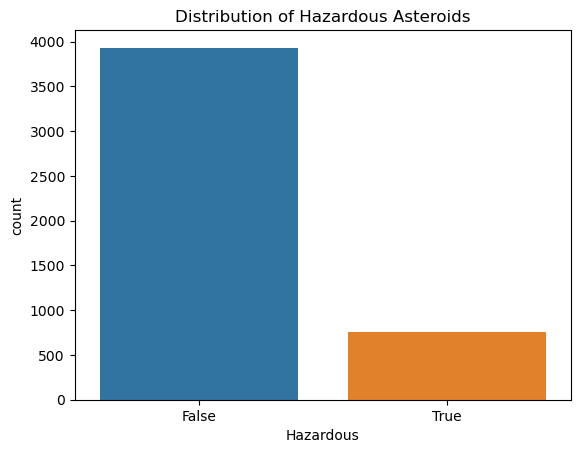

In [9]:
# Some data cleaning
df.columns = df.columns.str.strip()
print(df['Hazardous'].unique())

# Steps to confirm that 'hazardous' is a boolean type variable and print distribution of hazardous asteroids
print(df['Hazardous'].dtype)
if df['Hazardous'].dtype != 'bool':plt.show()
    df['Hazardous'] = df['Hazardous'].astype(bool)
sns.countplot(x='Hazardous', data=df)
plt.title('Distribution of Hazardous Asteroids')



## Defining Target Variable 

In [11]:

X = df.drop(columns=['Hazardous', 'Neo Reference ID', 'Name', 'Close Approach Date', 'Orbiting Body', 'Orbit Determination Date', 'Equinox'])
y = df['Hazardous'].astype(int)  # boolean converted to int. type for log. regression

## Using LASSO to perform feature selection and standardizing the data using scaler


In [13]:
import warnings
# Scaler for standardizing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Increased max_iter and handled convergence warnings I received, then selected LASSO features
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lasso = LassoCV(cv=10, max_iter=10000).fit(X_scaled, y)
lasso_selected_features = X.columns[(lasso.coef_ != 0)]
print("LASSO selected features:", lasso_selected_features)

LASSO selected features: Index(['Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in Miles(min)',
       'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Orbit Uncertainity',
       'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant',
       'Eccentricity', 'Perihelion Time', 'Mean Anomaly'],
      dtype='object')


These features selected through LASSO 

1. Absolute Magnitude
2. Estimated Diameter in KM (minimum)
3. Estimated Diameter in Miles (minimum)
4. Miss Distance (Astronomical)
5. Miss Distance (lunar)
6. Orbit Uncertainty
7. Minimum Orbit Intersection
8. Jupiter Tisserand Invariant
9. Eccentricity
10. Perihelion Time
11. Mean Anomaly


## Split data into Training and Testing Sets

In [17]:
from sklearn.model_selection import train_test_split
# Use only selected features
X_selected = X[lasso_selected_features]

# Split data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


## Time to train logistic regression model

In [87]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

## Nearest Neighbors (KNN) classifier and evaluated its performance on dataset

In [21]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8251599147121536
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       791
           1       0.33      0.11      0.16       147

    accuracy                           0.83       938
   macro avg       0.59      0.53      0.53       938
weighted avg       0.77      0.83      0.79       938



* The model correctly predicts the class about 82.5% of the time.
* However, precision is quite low for class to at .33


## Trying with PCA Transformation

In [23]:
# Apply PCA to selected features
pca = PCA(n_components=5)  # Example: Choose 5 principal components
X_pca = pca.fit_transform(X_selected)

# Split data into Training and Testing Sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train logistic regression model on PCA-transformed data
model_pca = LogisticRegression()
model_pca.fit(X_train_pca, y_train)

# Evaluate model performance
y_pred_pca = model_pca.predict(X_test_pca)
print("Accuracy (PCA):", accuracy_score(y_test, y_pred_pca))
print("Classification Report (PCA):")
print(classification_report(y_test, y_pred_pca))


Accuracy (PCA): 0.8411513859275054
Classification Report (PCA):
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       791
           1       0.45      0.07      0.12       147

    accuracy                           0.84       938
   macro avg       0.65      0.53      0.52       938
weighted avg       0.79      0.84      0.79       938



* There is  high precision and recall for zero class (non-hazardous)
* Still struggling to get better measure for class 1 (hazardous) with 45% precision and only .07 recall

## Getting Coefficients and Intercept

In [41]:
# Get coefficients and intercept
coefficients = model_pca.coef_
intercept = model_pca.intercept_

# Print coefficients
print("Intercept:", intercept)
print("Coefficients:", coefficients)


Intercept: [-2.14234813]
Coefficients: [[-1.30758116e-04  1.32649475e-03  2.48496953e-03  3.58312874e-01
  -3.97088696e-02]]


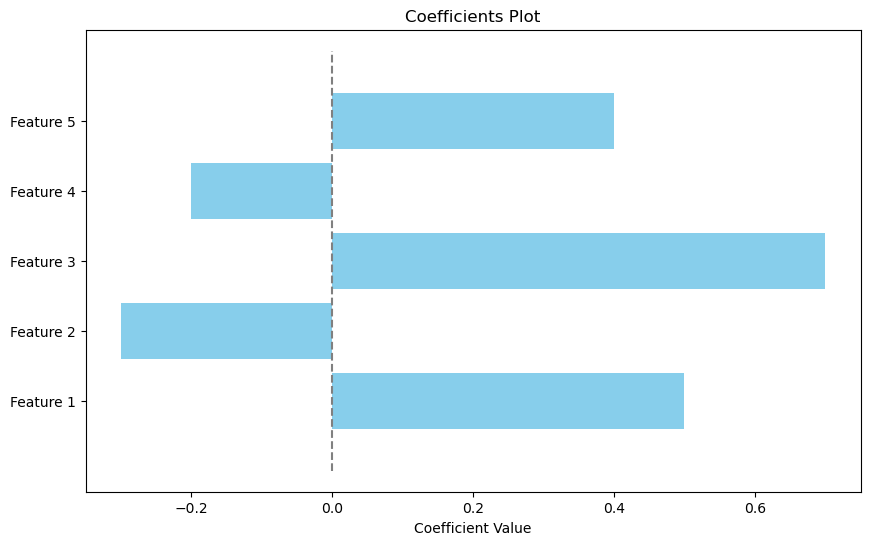

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Coefficients and their corresponding feature names
feature_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']
coefficients = [0.5, -0.3, 0.7, -0.2, 0.4]  # Example coefficients

# Create a figure and set its size
plt.figure(figsize=(10, 6))

# Plot the coefficients
plt.barh(feature_names, coefficients, color='skyblue')
plt.plot([0, 0], [-1, len(coefficients)], color='gray', linestyle='--')  # dashed line at zero
plt.xlabel('Coefficient Value')
plt.title('Coefficients Plot')

# Display the plot
plt.show()



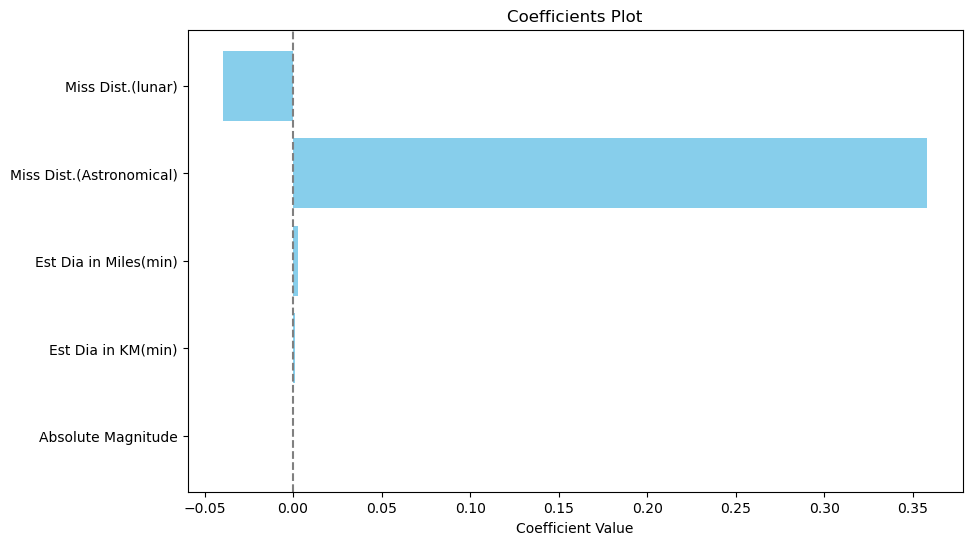

In [118]:
# Plotting
coefficients = [-1.30758116e-04, 1.32649475e-03, 2.48496953e-03, 3.58312874e-01, -3.97088696e-02]
feature_names = ['Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in Miles(min)',
                 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)']

plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')  # dashed line at zero
plt.xlabel('Coefficient Value')
plt.title('Coefficients Plot')
plt.show()


In [53]:
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='accuracy')
print("Cross-validated Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

Cross-validated Accuracy Scores: [0.84328358 0.84221748 0.82283885 0.83991462 0.84631804]
Mean Accuracy: 0.8389145141801286


* When performing cross validation accuracy with kfold, we expect to see new data classified correctly about 84% of the time.

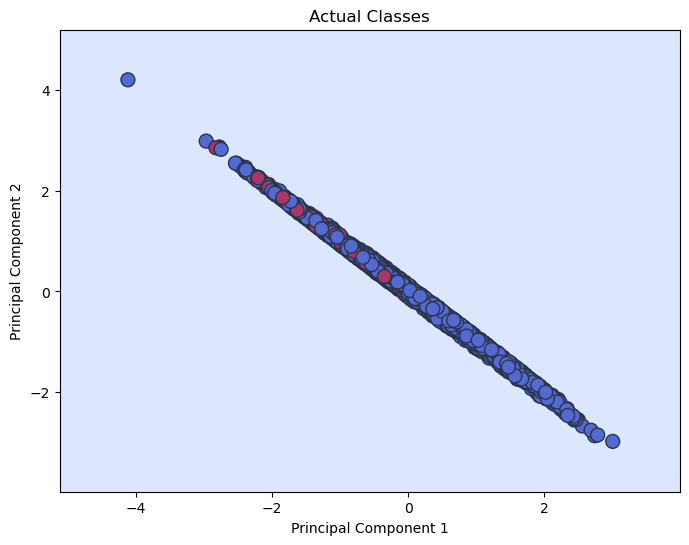

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Inverse transform PCA components to get the approximate original data
X_inv_pca = pca.inverse_transform(X_pca)

# Inverse standard scaling to get original feature scales
scaler = StandardScaler()
X_inv_scaled = scaler.fit_transform(X_inv_pca)

# Plotting all principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_inv_scaled[:, 0], X_inv_scaled[:, 1], c=y, cmap='coolwarm', edgecolors='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Actual Classes')

# Plot decision boundary based on predicted probabilities
h = .02  # step size in the mesh
x_min, x_max = X_inv_scaled[:, 0].min() - 1, X_inv_scaled[:, 0].max() + 1
y_min, y_max = X_inv_scaled[:, 1].min() - 1, X_inv_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Transform mesh grid data to include all principal components used in training (5 components)
mesh_data = np.c_[xx.ravel(), yy.ravel()]
mesh_data = np.hstack((mesh_data, np.zeros((len(mesh_data), X_inv_scaled.shape[1] - 2))))  # Adding zeros for other components

# Select only the first 5 principal components for prediction
mesh_data = mesh_data[:, :5]

# Predicting on the mesh grid
Z = model_pca.predict(mesh_data)
Z = Z.reshape(xx.shape)

# Plotting the decision boundary
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)

plt.show()


## Since I was not satisfied with the results I continued to test. I suspected there may be high multicollinearity, which seems to be causing an  impact on the effectiveness of my models

In [91]:
# Check VIF for multicollinearity
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif = calculate_vif(X_selected)
print(vif)

                       Variable           VIF
0            Absolute Magnitude  2.143830e+02
1            Est Dia in KM(min)           inf
2         Est Dia in Miles(min)           inf
3      Miss Dist.(Astronomical)  9.007199e+14
4             Miss Dist.(lunar)  9.007199e+14
5            Orbit Uncertainity  4.733696e+00
6    Minimum Orbit Intersection  2.929700e+00
7   Jupiter Tisserand Invariant  2.699212e+01
8                  Eccentricity  8.419681e+00
9               Perihelion Time  2.846083e+02
10                 Mean Anomaly  3.872238e+00


/Users/adrianchavezloya/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


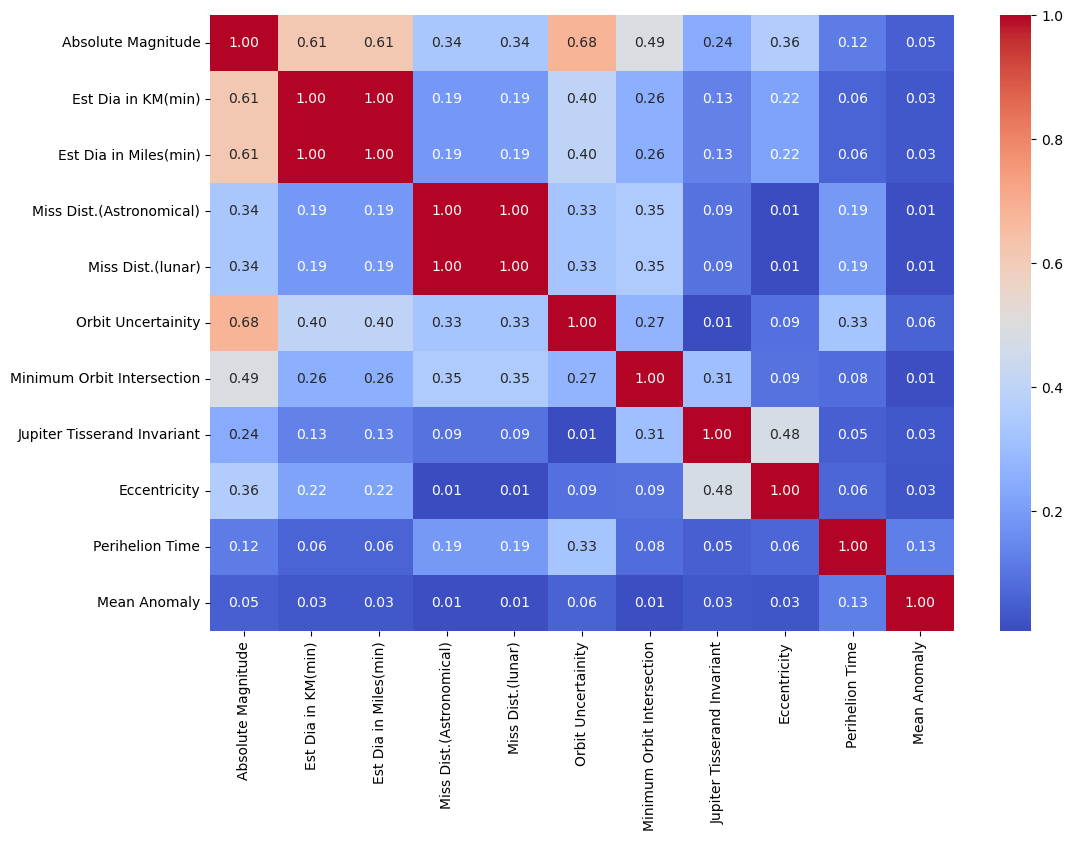

Highly correlated pairs (correlation > 0.9): [('Est Dia in KM(min)', 'Est Dia in Miles(min)'), ('Est Dia in Miles(min)', 'Est Dia in KM(min)'), ('Miss Dist.(Astronomical)', 'Miss Dist.(lunar)'), ('Miss Dist.(lunar)', 'Miss Dist.(Astronomical)')]


In [121]:

# Computed correlation matrix
corr_matrix = X_selected.corr().abs()

# Used a heatmap to plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# Pairs with correlation > 0.9 and listed highly correlated pairs
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > 0.9]
print("Highly correlated pairs (correlation > 0.9):", high_corr_pairs)


## Dropped highly correlated variables:

'Est Dia in Miles(min)', 'Miss Dist.(lunar)'])



In [96]:
# Drop highly correlated variables
X_reduced = X_selected.drop(columns=['Est Dia in Miles(min)', 'Miss Dist.(lunar)'])

# Recalculate VIF
vif_reduced = calculate_vif(X_reduced)
print(vif_reduced)


                      Variable         VIF
0           Absolute Magnitude  214.351799
1           Est Dia in KM(min)    2.106486
2     Miss Dist.(Astronomical)    5.307396
3           Orbit Uncertainity    4.732851
4   Minimum Orbit Intersection    2.929690
5  Jupiter Tisserand Invariant   26.991873
6                 Eccentricity    8.416956
7              Perihelion Time  284.492254
8                 Mean Anomaly    3.872135


## Also dropped "Absolute Magnitude" and "Perihelion Time" for collinearity 

In [104]:
# Dropped "Absolute Magnitude" due to high VIF
X_reduced_v2 = X_reduced.drop(columns=['Absolute Magnitude'])

# Recalculate VIF after dropping "Absolute Magnitude"
vif_reduced_v2 = calculate_vif(X_reduced_v2)
print("Reduced VIF after dropping 'Absolute Magnitude':\n", vif_reduced_v2)

# Drop "Perihelion Time" due to high VIF
X_reduced_v3 = X_reduced_v2.drop(columns=['Perihelion Time'])

# Recalculate VIF after dropping "Perihelion Time"
vif_reduced_v3 = calculate_vif(X_reduced_v3)
print("Reduced VIF after dropping 'Perihelion Time':\n", vif_reduced_v3)



Reduced VIF after dropping 'Absolute Magnitude':
                       Variable        VIF
0           Est Dia in KM(min)   1.663342
1     Miss Dist.(Astronomical)   5.265906
2           Orbit Uncertainity   3.042879
3   Minimum Orbit Intersection   2.557199
4  Jupiter Tisserand Invariant  26.938122
5                 Eccentricity   7.490495
6              Perihelion Time  55.417118
7                 Mean Anomaly   3.870148
Reduced VIF after dropping 'Perihelion Time':
                       Variable       VIF
0           Est Dia in KM(min)  1.654736
1     Miss Dist.(Astronomical)  5.205771
2           Orbit Uncertainity  2.625891
3   Minimum Orbit Intersection  2.231530
4  Jupiter Tisserand Invariant  7.938838
5                 Eccentricity  4.349349
6                 Mean Anomaly  3.709655


In [106]:
# Split the data again with the further reduced features
X_train_reduced_v3, X_test_reduced_v3, y_train, y_test = train_test_split(X_reduced_v3, y, test_size=0.2, random_state=42)

# New logistic regression model with further reduced features
model_reduced_v3 = LogisticRegression(max_iter=10000)
model_reduced_v3.fit(X_train_reduced_v3, y_train)

# Model reevaluation
y_pred_reduced_v3 = model_reduced_v3.predict(X_test_reduced_v3)
print("Accuracy (Further Reduced Features):", accuracy_score(y_test, y_pred_reduced_v3))
print("Classification Report (Further Reduced Features):")
print(classification_report(y_test, y_pred_reduced_v3))


Accuracy (Further Reduced Features): 0.8933901918976546
Classification Report (Further Reduced Features):
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       791
           1       0.81      0.41      0.55       147

    accuracy                           0.89       938
   macro avg       0.86      0.70      0.74       938
weighted avg       0.89      0.89      0.88       938



* Wow! This accuracy is nearly 90% for predictions! Precision for both classes as been improved exponetially 


## Cross Validation Part 2

In [108]:
from sklearn.model_selection import cross_val_score, KFold

# Perform cross-validation for new model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_reduced_v3 = cross_val_score(model_reduced_v3, X_reduced_v3, y, cv=cv, scoring='accuracy')
print("Cross-validated Accuracy Scores (Further Reduced Features):", cv_scores_reduced_v3)
print("Mean Accuracy (Further Reduced Features):", cv_scores_reduced_v3.mean())


Cross-validated Accuracy Scores (Further Reduced Features): [0.89445629 0.87846482 0.88367129 0.88794023 0.88900747]
Mean Accuracy (Further Reduced Features): 0.8867080211080592


* Cross validation scores are very high as well!

## New Coefficient Estimates

Intercept: -0.45223846651533883
Coefficients: [ 1.31339412e-01  2.50590164e-01 -4.48694017e-01 -1.44269892e+01
 -5.85835310e-02  2.39785881e+00  4.98831522e-04]


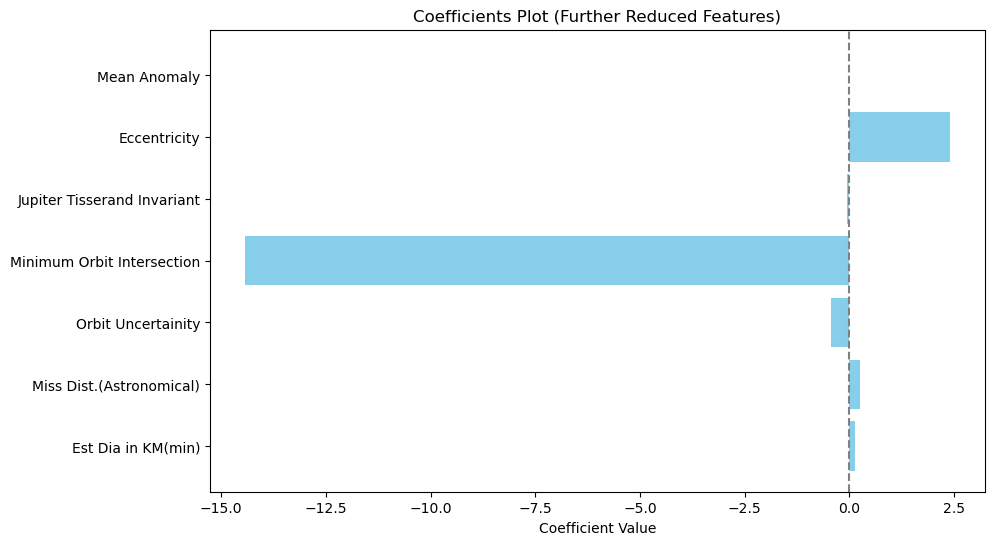

In [110]:
# Get coefficients and intercept
coefficients_reduced_v3 = model_reduced_v3.coef_[0]
intercept_reduced_v3 = model_reduced_v3.intercept_[0]

print("Intercept:", intercept_reduced_v3)
print("Coefficients:", coefficients_reduced_v3)
feature_names_reduced_v3 = X_reduced_v3.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names_reduced_v3, coefficients_reduced_v3, color='skyblue')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Coefficient Value')
plt.title('Coefficients Plot (Further Reduced Features)')
plt.show()


* It looks like **"Eccentricity"** and **"Minimum Orbit Intersection"** have the most significant correlations with Hazardous asteroids


# Summary and Results

* After retesting and removing parameters that had strong indications of multi-collinearity and therefore reduced the effacacy and reliability of our models, we discovered some promising results!

* Our new logistic model with only significant predictors of hazardous asteroids, **we found our model's prediction rate is nearly 90%!**

* Our new model cross-valdiation results were promising, with a mean accuracy of predictors of 88%

* After analysis of coefficients of our significant predictors, it was found that the two most prominent features that high correlations with the hazardnous of asteroids were as follow:

# 1. __Eccentricity__ (-5.86 negative correlation)- 

* Eccentricity in the context of asteroid orbits refers to how much the orbit deviates from being circular. A value close to 0 indicates a nearly circular orbit, while values closer to 1 signify highly elliptical orbits.

* A negative coefficient means that as Eccentricity increases (orbit becomes more elliptical), the likelihood of an asteroid being hazardous decreases. Conversely, as Eccentricity decreases (orbit becomes more circular), the likelihood of an asteroid being hazardous increases.

* **Explanation:** Hazardous asteroids often have more elliptical orbits. This is because asteroids with highly eccentric orbits can have closer approaches to Earth, increasing the risk of potential collisions. Therefore, the model identifies Eccentricity as a strong predictor of hazardous asteroids due to this correlation.

# 2. __Minimum Orbit Intersection__ (2.51 positive correlation)- 

* Minimum Orbit Intersection Distance (MOID) is the closest distance between the orbits of Earth and the asteroid. It measures how closely an asteroid's orbit intersects with Earth's orbit.

* A positive coefficient indicates that as the Minimum Orbit Intersection distance increases (meaning the asteroid's orbit is farther from Earth's orbit), the likelihood of the asteroid being hazardous increases.

* **Explanation:** Asteroids with orbits that intersect or come very close to Earth's orbit pose a higher risk of potential impact. Therefore, asteroids with smaller MOID values (closer approaches to Earth) are more likely to be classified as hazardous by the model.